In [1]:
!unzip HODA.zip

Archive:  HODA.zip
  inflating: Train 60000.cdb         
  inflating: RemainingSamples.cdb    
  inflating: Test 20000.cdb          


In [2]:
!pip install pure-cdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import struct
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import keras
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score , recall_score, f1_score, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from keras.optimizers import SGD,Adam,Adadelta


In [4]:
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image



In [5]:

def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0] 
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  
                        else:
                            image[y, counter:counter + WBcount] = 255  
                        bWhite = not bWhite  
                        counter += WBcount
            else:
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


In [6]:
def read_hoda_dataset(dataset_path, images_height=40, images_width=40, one_hot=True, reshape=False):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [7]:
def accuracy_plot(history):
  fig = plt.figure()
  plt.plot(history.history['accuracy'],'r')
  plt.plot(history.history['val_accuracy'],'b')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'])
  plt.grid()

def loss_plot(history):
  fig = plt.figure()
  plt.plot(history.history['loss'],'r')
  plt.plot(history.history['val_loss'],'b')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'])
  plt.grid()

def report(model , x_test , y_test ):
  Y_pred = model.predict(x_test)
  y_pred = np.argmax(Y_pred, axis=1)
  Y_test = np.argmax(y_test, axis=1)

  test_loss,test_accuracy = model.evaluate(x_test,y_test)
  print('test loss = %f' % test_loss)
  print('test accuracy = %f' % test_accuracy)
  accuracy = accuracy_score(Y_test, y_pred)
  print('Accuracy: %f' % accuracy)
  precision = precision_score(Y_test, y_pred, average='macro')
  print('Precision: %f' % precision)
  recall = recall_score(Y_test, y_pred, average='macro')
  print('Recall: %f' % recall)
  f1 = f1_score(Y_test, y_pred, average='macro')
  print('F1 score: %f' % f1)

  fig = plt.figure()
  print(classification_report(Y_test, y_pred))
  mat = confusion_matrix(Y_test, y_pred, normalize="true")
  sns.heatmap(mat, annot=True, cmap='Spectral')
  plt.title('model loss')

In [8]:
def model_dcnn():
  model = Sequential()
  model.add(SeparableConv2D(64, (3, 3), padding="same", input_shape=(40,40,1)))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=1))
  model.add(MaxPooling2D(pool_size=(3, 3),strides = (2,2)))
  model.add(Dropout(0.1))
  model.add(SeparableConv2D(128, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=1))
  model.add(SeparableConv2D(128, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=1))
  model.add(MaxPooling2D(pool_size=(3, 3),strides = (2,2)))
  model.add(Dropout(0.2))
  model.add(SeparableConv2D(256, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=1))
  model.add(SeparableConv2D(256, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=1))
  model.add(MaxPooling2D(pool_size=(3, 3),strides = (2,2)))
  model.add(Dropout(0.3))
  model.add(SeparableConv2D(512, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=1))
  model.add(SeparableConv2D(512, (3, 3), padding="same"))
  model.add(BatchNormalization(axis=1))
  model.add(MaxPooling2D(pool_size=(3, 3),strides = (2,2)))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1024, activation="relu"))
  model.add(BatchNormalization(axis=1))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation="softmax"))
  return model

In [9]:
x_train,y_train = read_hoda_dataset("Train 60000.cdb")
x_test,y_test = read_hoda_dataset("Test 20000.cdb")


<ipython-input-6-73b3085cdfce>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.zeros(shape=[len(labels)], dtype=np.int)


In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train.shape

(60000, 40, 40, 1)

# **ADAM**

In [43]:
model_adm = model_dcnn()
model_adm.compile("Adam", loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model_adm.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/100
469/469 [==============================] - 22s 43ms/step - loss: 0.2738 - accuracy: 0.9189 - val_loss: 7.1242 - val_accuracy: 0.1447
Epoch 2/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0457 - accuracy: 0.9866 - val_loss: 0.0521 - val_accuracy: 0.9851
Epoch 3/100
469/469 [==============================] - 23s 48ms/step - loss: 0.0300 - accuracy: 0.9902 - val_loss: 0.0288 - val_accuracy: 0.9918
Epoch 4/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0262 - accuracy: 0.9920 - val_loss: 0.0335 - val_accuracy: 0.9911
Epoch 5/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0226 - accuracy: 0.9931 - val_loss: 0.0263 - val_accuracy: 0.9922
Epoch 6/100
469/469 [==============================] - 21s 44ms/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 0.0242 - val_accuracy: 0.9934
Epoch 7/100
469/469 [==============================] - 22s 46ms/step - loss: 0.0179 - accuracy: 0.9944 - val_loss: 0.0404 - val_ac

625/625 [==============================] - 3s 5ms/step - loss: 0.0350 - accuracy: 0.9951
test loss = 0.035012
test accuracy = 0.995100
Accuracy: 0.995100
Precision: 0.995170
Recall: 0.995100
F1 score: 0.995107
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000
           2       0.99      0.98      0.99      2000
           3       0.97      1.00      0.98      2000
           4       1.00      0.98      0.99      2000
           5       1.00      1.00      1.00      2000
           6       1.00      1.00      1.00      2000
           7       1.00      1.00      1.00      2000
           8       1.00      1.00      1.00      2000
           9       1.00      1.00      1.00      2000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



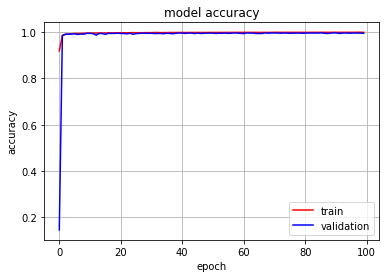

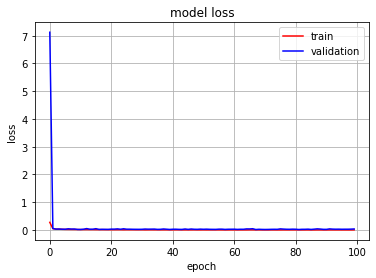

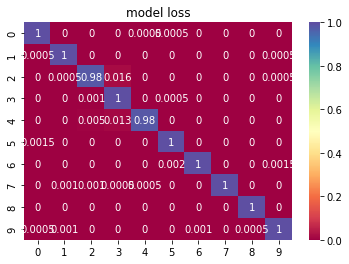

In [44]:
accuracy_plot(history1)
loss_plot(history1)
report(model_adm , x_test , y_test )

# **ADADELTA**

In [46]:
model_adadelta = model_dcnn()
model_adadelta.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model_adadelta.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/100
469/469 [==============================] - 22s 44ms/step - loss: 3.5735 - accuracy: 0.1113 - val_loss: 2.5313 - val_accuracy: 0.1000
Epoch 2/100
469/469 [==============================] - 20s 43ms/step - loss: 3.3740 - accuracy: 0.1359 - val_loss: 2.1891 - val_accuracy: 0.1775
Epoch 3/100
469/469 [==============================] - 20s 43ms/step - loss: 3.2227 - accuracy: 0.1537 - val_loss: 2.0666 - val_accuracy: 0.2779
Epoch 4/100
469/469 [==============================] - 20s 43ms/step - loss: 3.0770 - accuracy: 0.1771 - val_loss: 2.0190 - val_accuracy: 0.2893
Epoch 5/100
469/469 [==============================] - 20s 43ms/step - loss: 2.9548 - accuracy: 0.2017 - val_loss: 1.9917 - val_accuracy: 0.2889
Epoch 6/100
469/469 [==============================] - 20s 43ms/step - loss: 2.8318 - accuracy: 0.2181 - val_loss: 1.9651 - val_accuracy: 0.2978
Epoch 7/100
469/469 [==============================] - 20s 43ms/step - loss: 2.6895 - accuracy: 0.2459 - val_loss: 1.9312 - val_ac

625/625 [==============================] - 4s 6ms/step - loss: 0.1829 - accuracy: 0.9439
test loss = 0.182888
test accuracy = 0.943950
Accuracy: 0.943950
Precision: 0.947804
Recall: 0.943950
F1 score: 0.944315
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2000
           1       0.95      0.99      0.97      2000
           2       0.82      0.95      0.88      2000
           3       0.95      0.92      0.93      2000
           4       0.90      0.97      0.93      2000
           5       0.99      0.93      0.96      2000
           6       0.98      0.87      0.92      2000
           7       1.00      0.90      0.94      2000
           8       0.99      0.98      0.99      2000
           9       0.97      0.93      0.95      2000

    accuracy                           0.94     20000
   macro avg       0.95      0.94      0.94     20000
weighted avg       0.95      0.94      0.94     20000



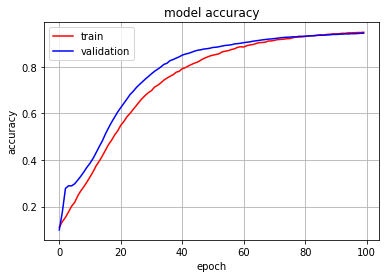

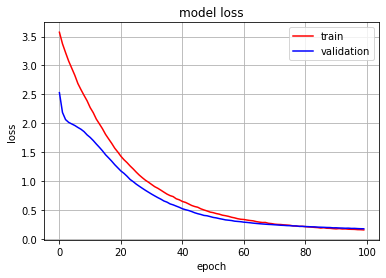

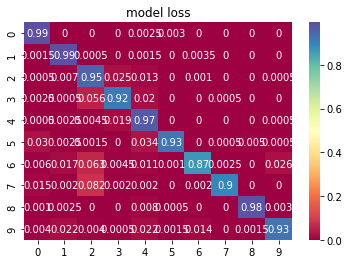

In [47]:
accuracy_plot(history2)
loss_plot(history2)
report(model_adadelta , x_test , y_test )

# **MOMENTUM**

In [11]:
model_mom = model_dcnn()
model_mom.compile(optimizer=SGD(momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model_mom.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/100
469/469 [==============================] - 35s 44ms/step - loss: 0.4657 - accuracy: 0.8593 - val_loss: 3.5812 - val_accuracy: 0.3465
Epoch 2/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0556 - accuracy: 0.9832 - val_loss: 0.0530 - val_accuracy: 0.9844
Epoch 3/100
469/469 [==============================] - 21s 44ms/step - loss: 0.0369 - accuracy: 0.9888 - val_loss: 0.0345 - val_accuracy: 0.9898
Epoch 4/100
469/469 [==============================] - 21s 44ms/step - loss: 0.0284 - accuracy: 0.9909 - val_loss: 0.0363 - val_accuracy: 0.9885
Epoch 5/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0234 - accuracy: 0.9926 - val_loss: 0.0946 - val_accuracy: 0.9733
Epoch 6/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0211 - accuracy: 0.9933 - val_loss: 0.0275 - val_accuracy: 0.9923
Epoch 7/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0428 - val_ac

625/625 [==============================] - 4s 6ms/step - loss: 0.0190 - accuracy: 0.9964
test loss = 0.018995
test accuracy = 0.996400
Accuracy: 0.996400
Precision: 0.996405
Recall: 0.996400
F1 score: 0.996399
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00      2000
           2       0.99      0.99      0.99      2000
           3       0.99      0.99      0.99      2000
           4       0.99      1.00      0.99      2000
           5       1.00      1.00      1.00      2000
           6       1.00      1.00      1.00      2000
           7       1.00      1.00      1.00      2000
           8       1.00      1.00      1.00      2000
           9       1.00      1.00      1.00      2000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



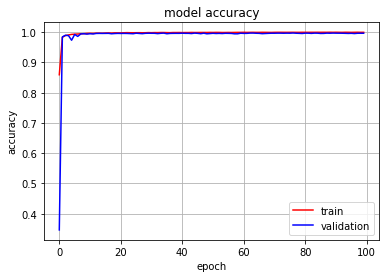

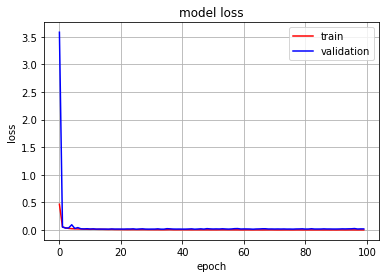

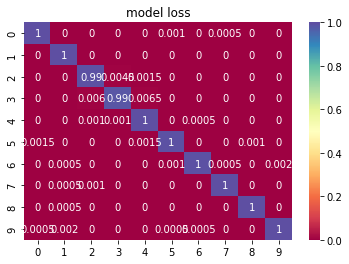

In [13]:
accuracy_plot(history1)
loss_plot(history1)
report(model_mom , x_test , y_test )